<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_Kaggle/blob/main/20221013_cat_in_the_dat_Ordinalencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 범주형 데이터 이진분류 경진대회
 - 다양한 범주형 데이터를 활용해 타깃값 1에 속할 확률 예측
 - 데이터 특성에 따른 맞춤형 인코딩 방법 이해
 - 문제유형 : 이진분류
 - 평가지표 : ROC AUC
 - 사용모델 : 로지스틱 회귀

 - 범주형 데이터

  > 값이 두개로만 구성된 이진 데이터 : bin_

  > 순서형 데이터 : ord_

  > 명목형 데이터 : nom_

  > 날짜 데이터 : day, month

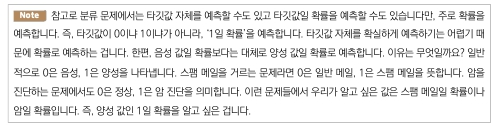

In [2]:
import numpy as np
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/cat-in-the-dat/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

### 피처 엔지니어링


#### 데이터 합치기
 - 머신러닝 모델 문자데이터 인식 불가
 - 일괄 숫자로 인코딩하기 위해 train, test 데이터 합친후 인코딩

In [3]:
train.shape, test.shape # 타깃값 피처가 존재

((300000, 24), (200000, 23))

In [4]:
# 훈련 데이터, 테스트 데이터 합치기
all_data = pd.concat([train, test])
all_data = all_data.drop('target', axis=1)  # 타깃값 피처 제거
all_data

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,0,F,N,Green,Square,Lion,Canada,Theremin,...,9e4b23160,acc31291f,1,Novice,Lava Hot,j,A,Gb,1,3
499996,1,0,0,F,Y,Green,Trapezoid,Lion,China,Piano,...,cfbd87ed0,eae3446d0,1,Contributor,Lava Hot,f,S,Ed,2,2
499997,0,1,1,T,Y,Green,Trapezoid,Lion,Canada,Oboe,...,1108bcd6c,33dd3cf4b,1,Novice,Boiling Hot,g,V,TR,3,1


In [5]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder() # 원-핫 인코더 객체생성
all_data_encoded = encoder.fit_transform(all_data)

In [10]:
all_data_encoded # 희소행렬(Compressed Sparse Row format)

<500000x16552 sparse matrix of type '<class 'numpy.float64'>'
	with 11500000 stored elements in Compressed Sparse Row format>

#### 데이터 나누기
 - 공통으로 적용할 인코딩이 끝났으므로 훈련, 테스트 데이터 다시 나눔

In [12]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터, 테스트 데이터 나누기
X_train = all_data_encoded[:num_train] # df[슬라이싱] : 슬라이싱 하는 경우 행을 기준으로 인식
X_test = all_data_encoded[num_train:]

y = train['target']

 - 훈련 데이터에서 임의로 검증 데이터를 분리

   > 모델 성능 평가를 위함

   > 타깃값 공정 배분을 위해 train_test_split() 사용

In [13]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y,
                                                      test_size=0.1,
                                                      stratify=y,
                                                      random_state=10)

In [14]:
X_train.shape, X_valid.shape

((270000, 16552), (30000, 16552))

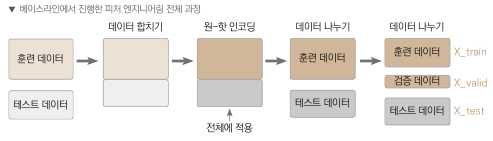

### 모델 훈련
 - 선형 회귀 방식으로 분류 : 로지스틱 회귀

In [15]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### 모델 성능 검증
 - 사이킷런은 타깃값 예측 메서드 두가지 제공 : predict(), predict_proba()

  > predict() : 0 or 1

  > predict_proba() : 0일 확률과 1일 확률 

In [16]:
logistic_model.predict_proba(X_valid)

array([[0.2327832 , 0.7672168 ],
       [0.91405072, 0.08594928],
       [0.83025789, 0.16974211],
       ...,
       [0.24862988, 0.75137012],
       [0.49420097, 0.50579903],
       [0.9565535 , 0.0434465 ]])

 - 타깃값 1일 '확률'을 예측하는 것이 목표
 - X_valid를 모델에 넣어 예측한 값과, y_valid 실제값의 비교

  > 얼마나 일치하는지 비교하는 방법 중 ROC AUC 이용

In [17]:
# 검증 데이터를 활용한 타깃 예측
y_valid_preds = logistic_model.predict_proba(X_valid)[:, 1]

In [18]:
from sklearn.metrics import roc_auc_score

# 검증 데이터 ROC AUC
roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

검증 데이터 ROC AUC : 0.7965


### 예측 결과 제출
 - 이제 테스트 데이터를 활용해 타깃값 1일 확률 예측

In [19]:
y_preds = logistic_model.predict_proba(X_test)[:, 1]

In [20]:
submission['target'] = y_preds
# submission.to_csv('submission.csv')

## 성능 개선 1
 - 1.피처 맞춤 인코딩
 - 2.피처 스케일링
 - 3.하이퍼파라미터 최적화 : 그리드 서치

In [21]:
import numpy as np
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/cat-in-the-dat/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

### 피처 엔지니어링 1 : 피처 맞춤 인코딩
 - 베이스라인에서는 모든 피처를 일괄적으로 원-핫 인코딩 함
 - 피처 특성에 맞는 인코딩 필요

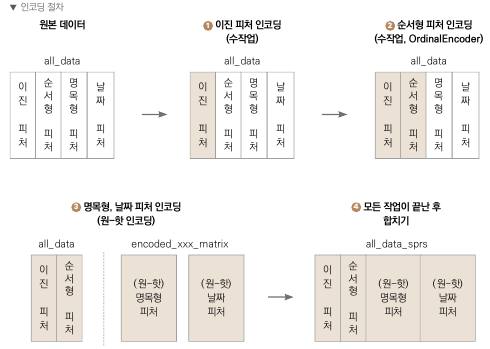

#### 데이터 합치기
 - 인코딩 전에 훈련 데이터와 테스트 데이터 합치고, 타깃값 제거

In [31]:
all_data = pd.concat([train, test])
all_data = all_data.drop('target', axis=1)

#### 이진 피처 인코딩
 - bin_0, bin_1, bin_2 피처 : 이미 0, 1로 구성
 - bin_3, bin_4 피처 : T/F, Y/N로 구성(→ 0/1로 인코딩)

In [32]:
all_data['bin_3'] = all_data['bin_3'].map({'F':0, 'T':1})  # Series.map(dict) : Series에만 적용 가능한 map() 함수
all_data['bin_4'] = all_data['bin_4'].map({'N':0, 'Y':1})
# all_data['bin_4'] = all_data['bin_4'].map(lambda x: 0 if x == 'N' else 1) # Series.map(lambda) : map() 함수는 dict 뿐 아니라 lambda도 적용 가능, df.apply() 함수는 dict 불가

#### 순서형 피처 인코딩

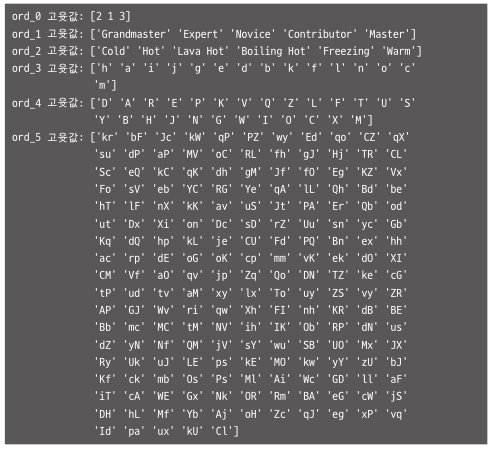

 - ord_0 피처 : 이미 숫자로 구성(인코딩 불필요)
 - ord_1, ord_2 피처 : 순서를 정해서 인코딩
 - ord_3, ord_4, ord_5 피처 : 알파벳 순으로 인코딩

  > 알파벳 순으로 인코딩 : 사이킷런의 OrdinalEncoder

In [33]:
ord1dict = {'Novice':0, 'Contributor':1, 'Expert':2, 'Master':3, 'Grandmaster':4}
ord2dict = {'Freezing':0, 'Cold':1, 'Warm':2, 'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}

all_data['ord_1'] = all_data['ord_1'].map(ord1dict)
all_data['ord_2'] = all_data['ord_2'].map(ord2dict)

In [34]:
from sklearn.preprocessing import OrdinalEncoder

ord_345 = ['ord_3','ord_4','ord_5']

ord_encoder = OrdinalEncoder() # 인코더 객체 생성
all_data[ord_345] = ord_encoder.fit_transform(all_data[ord_345]) # 인코더 적용

In [35]:
ord_encoder.categories_ # 어떤순서로 ordinal 인코딩을 적용했는지 확인

[array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
       dtype=object),
 array(['AP', 'Ai', 'Aj', 'BA', 'BE', 'Bb', 'Bd', 'Bn', 'CL', 'CM', 'CU',
        'CZ', 'Cl', 'DH', 'DN', 'Dc', 'Dx', 'Ed', 'Eg', 'Er', 'FI', 'Fd',
        'Fo', 'GD', 'GJ', 'Gb', 'Gx', 'Hj', 'IK', 'Id', 'JX', 'Jc', 'Jf',
        'Jt', 'KR', 'KZ', 'Kf', 'Kq', 'LE', 'MC', 'MO', 'MV', 'Mf', 'Ml',
        'Mx', 'NV', 'Nf', 'Nk', 'OR', 'Ob', 'Os', 'PA', 'PQ', 'PZ', 'Ps',
        'QM', 'Qb', 'Qh', 'Qo', 'RG', 'RL', 'RP', 'Rm', 'Ry', 'SB', 'Sc',
        'TR', 'TZ', 'To', 'UO', 'Uk', 'Uu', 'Vf', 'Vx', 'WE', 'Wc', 'Wv',
        'XI', 'Xh', 'Xi', 'YC', 'Yb', 'Ye', 'ZR', 'ZS', 'Zc', 'Zq', 'aF',
        'aM', 'aO', 'aP', 'ac', 'av', 'bF', 'bJ', 'be', 'cA', 'cG', 'cW',
        'ck', 'cp', 'dB', 'dE', 'dN', 'dO', 'dP', 'dQ', 'd

In [36]:
all_data[ord_345]

,ord_3,ord_4,ord_5
id,,,
0,7.0,3.0,136.0
1,0.0,0.0,93.0
2,7.0,17.0,31.0
3,8.0,3.0,134.0
4,0.0,17.0,158.0
...,...,...,...
499995,9.0,0.0,25.0
499996,5.0,18.0,17.0
499997,6.0,21.0,66.0


 - ord_encoder.categories_ 순서로 0.0, 1.0, ... 인코딩

#### 명목형 피처 인코딩
 - 순서를 무시해도 되기 때문에 원-핫 인코딩 적용

In [37]:
# nom_0 부터 nom_9 까지 피처명 리스트
nom_features = ['nom_' + str(i) for i in range(10)] # list comprehension 활용